# Microsoft Movie Analysis
- **Authors:** Kevin Culver
***

 <img src = "./images/movie_posters.jpeg" width = 75%, align = center/>
 

## Overview
***

The aim of the current project was to provide actionable insights for Microsoft as it launches a new movie production studio. The project analyzed databases to identify variables that contribute to a movie's success at the box office. Analysis showed that certain factors, such as a film's genre, budget, rating, or release date were related to higher profit and return on investment.

## Business Problem
***

Creating a successful movie studio takes time, money, and risk. However, a company cannot predict how the movies it produces will be received. Therefore, the point of this analysis was to find what qualities are shared by high grossing films that make them successful. For the present analysis, four questions were asked:
1. *What movie genres are most successful?*
2. *What time of year is best to release films?*
3. *Does budget size impact a movie's profit?*
4. *How does a movie's rating affect its profitability?*

By analyzing these questions, business recommendations can be provided that will assist Microsoft in making informed decisions about what types of films to create. 


## Data Understanding
***
The data used in this project comes from two online movie databases - iMDB and The Numbers. Within these databases, each movie is identified by its title or movie id. When combined, these databases provide comprehensive information for each movie, including its genre, rating, release date, budget, and total gross (both domestic and worldwide). 


### Importing Relevant Modules and Datasets

In [1]:
# Import standard packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from bs4 import BeautifulSoup
import requests

%matplotlib inline

In [2]:
#iMDB datasets
imdb_ratings = pd.read_csv('zippedData/imdb.title.ratings.csv.gz')
imdb_titles = pd.read_csv('zippedData/imdb.title.basics.csv.gz')

#The Numbers (movie budget dataset)
budget = pd.read_csv('zippedData/tn.movie_budgets.csv.gz')

### iMDB and The Numbers Datasets

#### iMDB Data
The two datasets imported from iMDB are: **imdb_ratings** and **imdb_titles**. 

The **imdb_ratings** database, provides the average ratings and number of votes for each movies.  The second database, **imdb_titles**, provides more info on each movie including it's title, runtime, start year, and genre. 


These two datasets can be easily joined since they share the unique movie identifier 'tconst'. In the cells below, the iMDB databases are joined using an inner join. 

In [3]:
#setting indexes to 'tconst' for each dataset to prep for inner join
imdb_titles.set_index('tconst', inplace=True)
imdb_ratings.set_index('tconst', inplace=True)

In [4]:
#joining dfs using inner join to get iMDB movies that contain both titles and ratings
imdb_titles_ratings = imdb_titles.join(imdb_ratings, how='inner')

imdb_titles_ratings.head(2)


,primary_title,original_title,start_year,runtime_minutes,genres,averagerating,numvotes
tconst,,,,,,,
tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama",7.0,77
tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.0,"Biography,Drama",7.2,43


At this point in the analysis, there are close to 74,000 entries. The start year's range from 2010-2019, but as we'll see this is column does not represent the movie's actual release date. 

#### The Numbers Data:

'The Numbers' dataset includes information on each movie's release date, title, budget, and total gross (both domestic and worldwide). The dataset contains 5782 entries.

In [5]:
budget.head(2)

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279"
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875"


#### Merging Datasets

The two tables are merge using the each entry's movie title since this is the only category shared between the two datasets. After merging, the new 'movies_df' table has 2638 entries.

In [6]:
#merging the two tables (imdb + budget) using movie titles
movies_df = pd.merge(imdb_titles_ratings, budget, right_on='movie', left_on='original_title')
movies_df.head(2)

,primary_title,original_title,start_year,runtime_minutes,genres,averagerating,numvotes,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,Foodfight!,Foodfight!,2012,91.0,"Action,Animation,Comedy",1.9,8248,26,"Dec 31, 2012",Foodfight!,"$45,000,000",$0,"$73,706"
1,The Overnight,The Overnight,2010,88.0,NaN,7.5,24,21,"Jun 19, 2015",The Overnight,"$200,000","$1,109,808","$1,165,996"


## Data Preparation
***

Data preparation for this dataset consisted of several steps. First, the data was cleaned by changing data types, dropping unnecessary columns, and finding duplicate values and dropping them. Part of this process entailed creating new columns to house the altered data. After the data was cleaned, another data frame was created to address a specific question related to movie genres.

### Data Cleaning:

#### Changing Data Types:
<u> Steps Taken: </u>

 1. Any column that deals with total gross is converted from an object dtype into an integer dtype to make analysis easier.
 
2. A new column **'production_profit'** is created to measure the actual profit of each movie after accounting for the cost of budget.


3. A column, **'date_released'** is added that changes the release date to a datetime object to make analysis easier.


4. Finally, another column, **'release_month'** is created by separating the month name from the datetime object. This will make categorical analysis easier when creating data models.

In [7]:
#Function to tranform money columns into cleaned integers dtyes
def money_cleaner(df, column_name, new_col_name):
    df[new_col_name] = df[column_name].map(lambda x: x.replace('$', ''))
    df[new_col_name] = df[new_col_name].map(lambda x: x.replace(',', ''))
    df[new_col_name] = pd.to_numeric(df[new_col_name])
    
    return df[new_col_name]

In [8]:
#cleaning budget column
budget_clean = money_cleaner(movies_df, 'production_budget', 'budget_clean')
movies_df['budget_clean'] = budget_clean

#cleaning worldwide_gross column
worldwide_gross = money_cleaner(movies_df, 'worldwide_gross', 'ww_gross_clean')
movies_df['ww_gross_clean'] = worldwide_gross

movies_df.head()

,primary_title,original_title,start_year,runtime_minutes,genres,averagerating,numvotes,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,budget_clean,ww_gross_clean
0,Foodfight!,Foodfight!,2012,91.0,"Action,Animation,Comedy",1.9,8248,26,"Dec 31, 2012",Foodfight!,"$45,000,000",$0,"$73,706",45000000,73706
1,The Overnight,The Overnight,2010,88.0,NaN,7.5,24,21,"Jun 19, 2015",The Overnight,"$200,000","$1,109,808","$1,165,996",200000,1165996
2,The Overnight,The Overnight,2015,79.0,"Comedy,Mystery",6.1,14828,21,"Jun 19, 2015",The Overnight,"$200,000","$1,109,808","$1,165,996",200000,1165996
3,On the Road,On the Road,2012,124.0,"Adventure,Drama,Romance",6.1,37886,17,"Mar 22, 2013",On the Road,"$25,000,000","$720,828","$9,313,302",25000000,9313302
4,On the Road,On the Road,2014,89.0,Drama,6.0,6,17,"Mar 22, 2013",On the Road,"$25,000,000","$720,828","$9,313,302",25000000,9313302


In [9]:
#Creates a production_profit column to determine how much profit each movie made
#after budget accounted for
movies_df['production_profit'] = movies_df['ww_gross_clean'] - movies_df['budget_clean']


In [10]:
#creating column with release date as datetime object
movies_df['date_released'] = pd.to_datetime(movies_df['release_date'])



In [11]:
#Creates release_month column and fills each row with the name of  its release 
#month
movies_df['release_month'] = movies_df['date_released'].dt.month_name()

#For readability in later analysis, only the firt 3 letters are retained for
#each month
movies_df['release_month'] = movies_df['release_month'].map(lambda x: x[:3])

***
The 'start_year' column is misleading. It does not always represent the actual release date. 
For example: "Action Jackson" came out in 1988, but the start date listed is 2014.

In the cell below, I correct the 'start_year' column by replacing it with the accurate year from 'release_date' column.

In [12]:
#replacing stary_year with correct year
movies_df['start_year'] = movies_df['release_date'].map(lambda x: x[-4:])

#The last step is to convert the column into an int64 dtype
movies_df['start_year'] = pd.to_numeric(movies_df['start_year'])


#### Dropping Unnecessary Columns
The titles dropped below are not used in later analysis, so they are dropped to make for a cleaner, more readable table.

In [13]:
movies_df.drop(labels=['original_title', 'id', 'movie', 'release_date', 
                       'production_budget', 'domestic_gross', 
                       'worldwide_gross'], axis=1, inplace=True)

#### Removing Duplicates and Null Values

There are 5 items without genres and 106 items without runtime with 2638 items in total. Since there are only 5 without genre, these items are dropped. 

Runtime is not used in this analysis, so no action is taken for these null values.


In [14]:
movies_df.head()

,primary_title,start_year,runtime_minutes,genres,averagerating,numvotes,budget_clean,ww_gross_clean,production_profit,date_released,release_month
0,Foodfight!,2012,91.0,"Action,Animation,Comedy",1.9,8248,45000000,73706,-44926294,2012-12-31,Dec
1,The Overnight,2015,88.0,NaN,7.5,24,200000,1165996,965996,2015-06-19,Jun
2,The Overnight,2015,79.0,"Comedy,Mystery",6.1,14828,200000,1165996,965996,2015-06-19,Jun
3,On the Road,2013,124.0,"Adventure,Drama,Romance",6.1,37886,25000000,9313302,-15686698,2013-03-22,Mar
4,On the Road,2013,89.0,Drama,6.0,6,25000000,9313302,-15686698,2013-03-22,Mar


In [15]:
movies_df.dropna(subset=['genres'], inplace=True)

In [16]:
movies_df.duplicated(subset='primary_title').sum()

541

There are 541 duplicate titles in the dataset that need to be dropped. After being dropped the total number of entries in the table is 2092. 


In [17]:
movies_df.drop_duplicates(keep='first', subset='primary_title', inplace=True)

#Sucessfully dropped duplicate entries
movies_df.shape

(2092, 11)

### Separating Genres and Creating New Data Frame
Each movie can have multiple genre designations. However, these designations are clumped together in a list and need to be separated for better, more accurate analysis. Below, a new data frame is created that creates a row for each genre designation for each movie.  

In [18]:
#Splits/seperates each genre category for each movie/row
movies_df['genres_list'] = movies_df['genres'].map(lambda x: x.split(','))
movies_df.head(2)

#Creates new df with each genre category represented in a row
genres_df = movies_df.explode('genres_list')
genres_df.head(5)

,primary_title,start_year,runtime_minutes,genres,averagerating,numvotes,budget_clean,ww_gross_clean,production_profit,date_released,release_month,genres_list
0,Foodfight!,2012,91.0,"Action,Animation,Comedy",1.9,8248,45000000,73706,-44926294,2012-12-31,Dec,Action
0,Foodfight!,2012,91.0,"Action,Animation,Comedy",1.9,8248,45000000,73706,-44926294,2012-12-31,Dec,Animation
0,Foodfight!,2012,91.0,"Action,Animation,Comedy",1.9,8248,45000000,73706,-44926294,2012-12-31,Dec,Comedy
2,The Overnight,2015,79.0,"Comedy,Mystery",6.1,14828,200000,1165996,965996,2015-06-19,Jun,Comedy
2,The Overnight,2015,79.0,"Comedy,Mystery",6.1,14828,200000,1165996,965996,2015-06-19,Jun,Mystery


In [19]:
movies_df.head(2)

,primary_title,start_year,runtime_minutes,genres,averagerating,numvotes,budget_clean,ww_gross_clean,production_profit,date_released,release_month,genres_list
0,Foodfight!,2012,91.0,"Action,Animation,Comedy",1.9,8248,45000000,73706,-44926294,2012-12-31,Dec,"[Action, Animation, Comedy]"
2,The Overnight,2015,79.0,"Comedy,Mystery",6.1,14828,200000,1165996,965996,2015-06-19,Jun,"[Comedy, Mystery]"


## Data Modeling and Evaluation
***

The organized data above has several categories that can be used for analysis. Since Microsoft is interested in creating successful, profitable movies, each relevant category is modeled based on its relation to production profit. 

The four categories used for modeling are: genre type, release month, movie budget, and movie rating. Each category is first charted and then evaluated. 

### Genre and Profitability: 

Genre type provides clear categories that can be charted and analyzed easily. By charting these categories using a barplot, it will become apparent if any genres are more profitable than others. If clear patterns become evident, these patterns can inform Microsoft's business decisions for what type of films to make.

In [20]:
# Orders the genres from most profitable to least. To be used in sns barplot
genre_means = genres_df.groupby('genres_list').mean()['production_profit']\
                                    .sort_values(ascending=False)
genre_means.index

Index(['Animation', 'Adventure', 'Sci-Fi', 'Action', 'Fantasy', 'Musical',
       'Family', 'Comedy', 'Thriller', 'Mystery', 'Music', 'Sport',
       'Biography', 'Horror', 'Crime', 'Drama', 'Romance', 'History',
       'Western', 'War', 'Documentary'],
      dtype='object', name='genres_list')

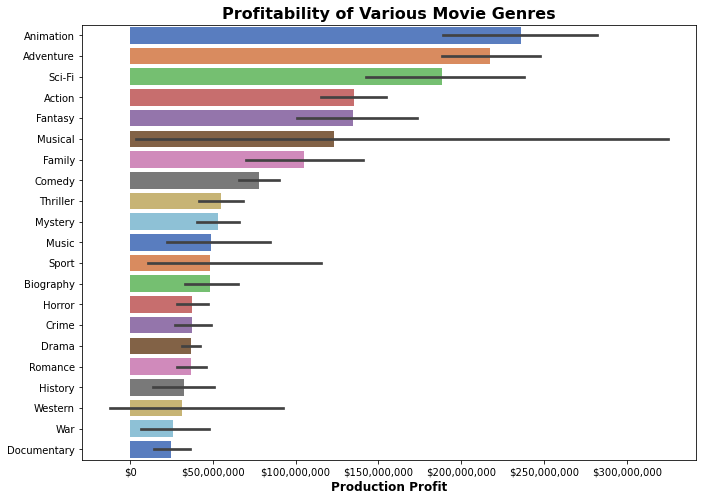

In [21]:
#since genres are categorical descriptions, a barchart will display the data
#the best
ax = sns.barplot(data=genres_df, y='genres_list', x='production_profit', 
                 order=genre_means.index, palette='muted')


ax.get_figure().set_size_inches((11, 8))

ax.set_xlabel('Production Profit', fontsize=12, fontweight='bold')
ax.xaxis.set_major_formatter("${x:,.0f}")

ax.set_ylabel(ylabel=None)
ax.set_title('Profitability of Various Movie Genres', fontsize=16, fontweight='bold')

#saving figure to images folder for use in README and presentation
plt.savefig('./images/genre_profit.png', facecolor='white');

### Genre Evaluation: 

It is evident that some genres are much more profitable than others. For example, the Animation genre is nearly ten times more profitable than the Documentary genre.

**The most profitable genre categories are:** 
1. Animation ($236 million)  

2. Adventure ($217 million)

3. Sci-fi ($189 million)

However, the next best performing category is harder to determine with the *action*, *fantasy*, and *musical* genres all earning around $125-135 million.

**The least profitable genre categories are:**
1. Documentary ($24.6 million)

2. War ($25.6 million)

There is also a clump of genre categories that perform similarly earning between $31 and 37 million. These genres (from least profitable to most): *history*, *romance*, *drama*, *crime*, and *horror*.


### Release Month and Profitability

Similar to genres, the release month provides clearly defined categories that can be charted easily using a barplot. By comparing the profitability of various release months, it can be visually determined what time of year are the best for releasing a movie. 

In [22]:
#Orders months by profit. Order will be used in sns plot below.
month_means = movies_df.groupby('release_month').mean()['production_profit']\
                                           .sort_values(ascending=False)
month_means

release_month
Jun    1.344192e+08
May    1.122625e+08
Jul    1.106925e+08
Nov    1.103317e+08
Mar    7.703935e+07
Dec    6.812520e+07
Feb    6.578280e+07
Apr    5.688355e+07
Aug    4.554133e+07
Oct    4.089157e+07
Jan    3.961325e+07
Sep    3.677364e+07
Name: production_profit, dtype: float64

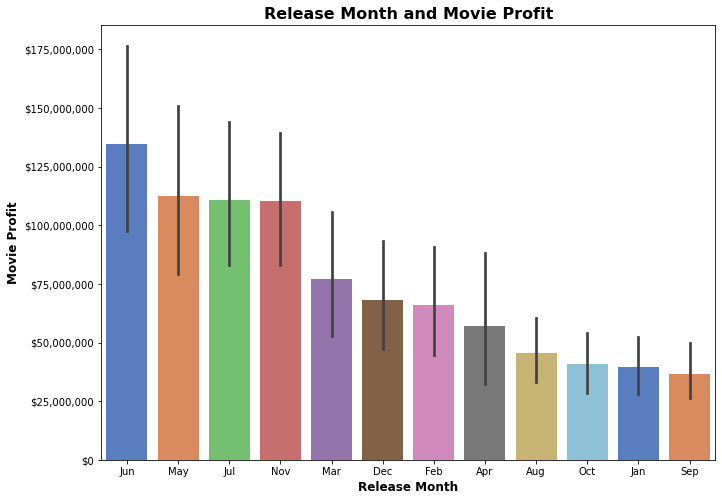

In [23]:
#Creating seaborn barplot
fig, ax = plt.subplots(figsize=(11,8))

ax = sns.barplot(data=movies_df, x='release_month', y='production_profit',
           order=month_means.index, palette='muted')

ax.set_xlabel('Release Month', fontsize=12, fontweight='bold')
ax.set_ylabel('Movie Profit', fontsize=12, fontweight='bold')
ax.yaxis.set_major_formatter("${x:,.0f}")
ax.set_title('Release Month and Movie Profit', fontsize=16, fontweight='bold')

#saving figure to images folder for use in README and presentation
plt.savefig('./images/month_profit.png', facecolor='white');

### Release Month Evaluation:

**The top three most profitable release months are:**
1. June ($134 million)

2. May ($112 milion)

3. July ($111 million)

All three of these months are during the summer months, indicating that people go out to see movies more in the summer than in the fall and winter.

The fourth most profitable month was **November**. Films are often released during the holiday season (around Thanksgiving) and many Americans have a tradition of going to the movies on Thanksgiving. This could also be a good month to release a movie

**The least profitable release months:**
1. September ($37 million)

2. January ($40 million)

3. October ($41 million)

4. August ($45 million)

Three out of the four lowest profit months occur in the fall (Aug-Oct), making the fall one of the worst times to release a film. This could be due to the end of summer holiday with kids and families going back to school and work routines.

### The Impact of Budget Size on Movie Profit

The basic question this model seeks to answer is: do movies with higher budgets produce higher profit? In other words, is budget positively related to profit? In this section, descriptive statistics are also provided to gain insight into the average and median budgets for movies. By answering these questions, Microsoft can have informed expectations and numbers when planning budgets for each film.

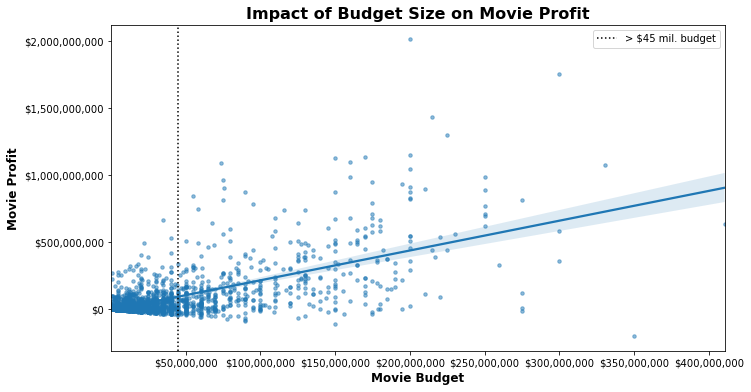

In [32]:
#The question of how budget impacts profit will be best visualized using a 
# regressional lineplot/scatter plot since it shows how these two factors are related
fig, ax = plt.subplots(figsize=(11,6))


sns.regplot(data=movies_df, x='budget_clean', y='production_profit', 
                     scatter_kws = dict(alpha=0.5, s=12))

plt.axvline(x=45000000, color='black', ls=':', label='> 45mil. budget')

labels = ['> $45 mil. budget']
handles, _ = ax.get_legend_handles_labels()

# Slice list to remove first handle
plt.legend(handles = handles, labels = labels)

ax.set_xlabel('Movie Budget', fontsize=12, fontweight='bold')
ax.xaxis.set_major_formatter("${x:,.0f}")
ax.set_ylabel('Movie Profit', fontsize=12, fontweight='bold')
ax.yaxis.set_major_formatter("${x:,.0f}")
ax.set_title('Impact of Budget Size on Movie Profit', fontsize=16, 
             fontweight='bold')
#saving figure to images folder for use in README and presentation
plt.savefig('./images/budget_profit.png', facecolor='white');

In [25]:
movies_df['budget_clean'].describe()

##Mean budget: $36.7 million
##Median budget: $18 million
##Top 75% of films: $45 million 

count    2.092000e+03
mean     3.669263e+07
std      5.024722e+07
min      1.400000e+03
25%      5.000000e+06
50%      1.800000e+07
75%      4.500000e+07
max      4.106000e+08
Name: budget_clean, dtype: float64

### Evaluation of Budget Size: 

There is a relatively strong correlation between movie budget size and profit. Specifically, after a budget surpasses 50 million dollars, there are more movies with more than a 500 million dollar profit. This indicates that movies with a higher budget are more likely to perform better in the box office. 

Several factors could contribute to this (e.g., better marketing, higher quality producers and actors, better visual effects). Further research could look into the budget of successful movies to see how to best allocate resources. 

Looking at the descriptive statistics, the median budget is 18 million and the top 25% of movies budget more than 45 million. These two numbers provide a reasonable range for setting budget parameters. 



**Descriptive Stats:**
- Mean budget: $37 million 

- Median budget: $18 million 

- 75th percentile: $45 million



### The Impact of Ratings on Profit

Finally, movie rating was considered to see if higher rated movies earn more profit. By modeling this question, Microsoft can set a minimum rating to aim for as they create movies. 

On the barplot, two lines were added representing the average rating and the top 25% most profitable moves. The visual is created here to show that movies with a higher than average rating tend to gross more at the box office. 

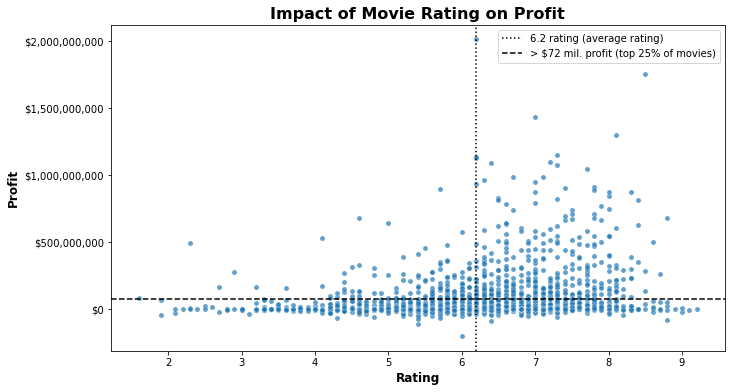

In [26]:
#Plotting scatterplot of movies rating and their profit to see distribution of
#ratings and movie profit
fig, ax = plt.subplots(figsize=(11,6))
plt.xticks()

ax = sns.scatterplot(data=movies_df,
                  y='production_profit', x='averagerating', palette='muted',
                     alpha=0.7, s=27)


plt.axvline(x=6.2, color='black', ls=':', label='6.4 rating')
plt.axhline(y=72000000, color='black', ls='--', label='profit')

labels = ['6.2 rating (average rating)', '> $72 mil. profit (top 25% of movies)']
handles, _ = ax.get_legend_handles_labels()

# Slice list to remove first handle
plt.legend(handles = handles, labels = labels)

ax.set_xlabel('Rating', fontsize=12, fontweight='bold')

ax.set_ylabel('Profit', fontsize=12, fontweight='bold')
ax.yaxis.set_major_formatter("${x:,.0f}")
ax.set_title("Impact of Movie Rating on Profit", fontsize=16, fontweight='bold')


#saving figure to images folder for use in README and presentation
plt.savefig('./images/rating_profit.png', facecolor='white');

In [27]:
movies_df['production_profit'].describe()


count    2.092000e+03
mean     7.385640e+07
std      1.708516e+08
min     -2.002376e+08
25%     -1.884277e+06
50%      1.149627e+07
75%      7.154787e+07
max      2.008208e+09
Name: production_profit, dtype: float64

### Evaluation of Rating's Impact:

On average, a movie earns a **6.2** rating with only 25% of films earning higher than a 7.0 rating and 25% earning below a 5.6. Profit-wise, the median profit is 11.5 million, with only 25% of movies making more than **72 million**. 

The visual above confirms these descriptive statistics. The distribution shows that there is a higher density of movies that earn more 72 million dollars in profit (horizontal line) after movies surpass a 6.2 rating (vertical line).

**Descriptive Statistics**:
- Mean rating: 6.23
- Median rating: 6.4
- Lower 25%: 5.6
- Upper 75%: 7.0
- Highest rating: 9.2

## Conclusions
***

The evaluation of the data above leads to four business recommendations for Microsoft's entry into movie production.

1.	**Limit creation of movies to certain genres.** Recommended genres are animation, adventure, sci-fi, or action since these genres generally earn higher profits. It is not recommended to produce movies within the documentary, war, or western genres due to historically poor performance at the box office. 
2. **Release movies during the summer months (May-June) and avoid releasing movies in the fall (Aug-Oct).** Movies released in the summer months have done significantly better than movies released during the fall. 
3.	**Budget at least 18 million dollars per movie for a lower budget film and at least 45 million dollars for a higher-budget, high-production movie.**  Higher budget films tend to have higher profit. The average budget for films is 18 million. However, after a budget of more than 45 million dollars, a film is more likely to produce greater profit.
4.	**Strive to release movies that earn at least a 6.2 rating.** Movies that earn higher than a 6.2 average rating are more likely to be successful at the box office and earn greater than 72 million dollars in profit.

## Next Steps
*** 
To further improve on the analysis done in this project. The following steps are recommended:

1. **Analyze the budgets of high-grossing, high budget films.** Several factors could contribute to higher budget films having higher profits (e.g., better marketing, top-tier producers and actors, better visual effects). Future research could look into budget distribution to obtain n insights for how to best allocate resources. 

2. **Analyze film characteristics among highly rated films.** The current project concluded  that movies with higher ratings (6.0 or higher) performed better at the box office; however, this finding is quite vague and doesn't produce tangible actions. To improve on this finding, further analysis could be conducted to find characteristics shared among highly-rated movies (e.g., screen-writing, visual effects, fan base, actors, directors). 

3. **Perform similar analysis with more recent movies.** One of the main limitations of this project was that it contained movies up to 2019, but did not include movies from 2020 or 2021. To see if these trends continue with more recent movies, it is recommended to collect and analyze data from more recent films.